<a href="https://colab.research.google.com/github/Parth722/NeuralNet/blob/main/nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start, importing required python libraries.

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

# Loading Mnist dataset into X and y with the help of sklearn utility functions. It contains 70000 images of handwritten digits with 28x28 pixels.

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = (X/255).astype('float32')


# Visualising some sample images.

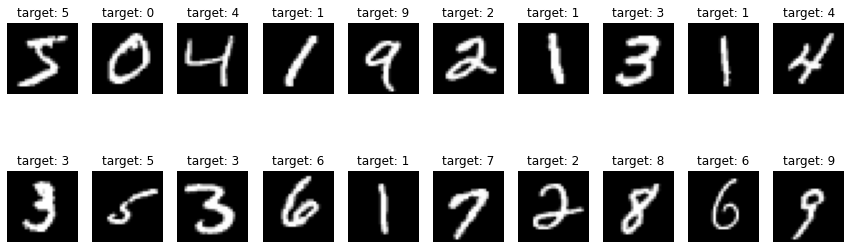

In [3]:
fig, axes = plt.subplots(2, 10, figsize=(15, 5))
for i in range(20):
    axes[i//10, i %10].imshow(X[i].reshape((28,28)), cmap='gray');
    axes[i//10, i %10].axis('off')
    axes[i//10, i %10].set_title(f"target: {y[i]}")

# One hot encoding. (Converting target(y) values from strings to a vector with y[i]th value is 1 while rest all are 0.

In [4]:
y = y.reshape(1, -1)
total = y.shape[1]
digits = 10
y_new = np.eye(digits)[y.astype('int32')]
y_new = y_new[0].astype('int32')


# Splitting Data into test and train datasets. Training set contains: 60000 examples. Test set contains: 10000 examples.

In [128]:
m = 60000 #number of training examples
m_test = X.shape[0] - m #number of test examples

X_train, y_train = X[:m], y_new[:m] 
#random shuffling of training set
random_sequence = np.random.permutation(m)
X_train, y_train = X_train[random_sequence, :], y_train[random_sequence, :] 

X_test, y_test = X[m:], y_new[m:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(60000, 784) (60000, 10) (10000, 784) (10000, 10)


# Class object to model Neural Network


In [91]:
class NeuralNet(object):
  
  """
    Class for n layer neural network.
    input_size: size of the input layer.
    hidden_dimension: size of the hidden layer.
    hidden_num: number of hidden layers.
    ouput_size: size of last layer, number of classes to be classified into.
    std: standard deviation for normal disbn (weights picked from normal disbn.)
  """

  def __init__(self, input_size, output_size, hidden_dimension=64, layer_num=3, std=1e-2):
    self.params = {} #empty dictionary to hold parameters.
    self.gradients = {} #empty dictionary to hold gradients.
    self.L = layer_num #number of layers

    #initializing weights and biases
    for i in range(layer_num-1):
      if i == 0:
        self.params['W1'] = std * np.random.randn(input_size, hidden_dimension)
        self.params['b1'] = np.zeros(hidden_dimension)
        continue
      self.params['W'+str(i+1)] = std * np.random.randn(hidden_dimension, hidden_dimension)
      self.params['b'+str(i+1)] = np.zeros(hidden_dimension)
    self.params['W'+str(layer_num)] = std * np.random.randn(hidden_dimension, output_size)
    self.params['b'+str(layer_num)] = np.zeros(output_size)

  """
    Helper functions for forward propagation:
  """

  #linear forward: computes: W*A_prev+b
  def linear_forward(self, A_prev, W, b):
    #returns Z = A_prev*W + b and cache which include W, A*prev, b for backward pass.
    Z = np.dot(A_prev,W) + b
    cache = (A_prev, W, b)
    return Z, cache
  
  #relu non linearity
  def relu_activation(self, Z):
    #returns relu(Z) and cache for backward pass
    A = np.maximum(0, Z)
    cache = Z

    return A, cache
  
  #sigmoid non linearity
  def sigmoid_activation(self, Z):
    #returns sigmoid(Z) and cache for backward pass
    A = 1/(1+np.exp(-Z))
    cache = Z

    return A, cache

  #compute A from A_prev, W, and b. 
  def linear_activation_forward(self, A_prev, W, b, activation):
    #implement forward propagation from linear -> activation
    Z, linear_cache = self.linear_forward(A_prev, W, b)
    
    if activation == "sigmoid":
      A, activation_cache = self.sigmoid_activation(Z)
    elif activation == "relu":
      A, activation_cache = self.relu_activation(Z)

    cache = (linear_cache, activation_cache)

    return A, cache
  
  #Defining softmax 
  def soft_max(self, x, y):
    x = x - np.amax(x, axis=1, keepdims=True)
    e_x = np.exp(x)
    softmax_score = e_x / np.sum(e_x, axis=1, keepdims=True)
    cache = (x, y, softmax_score)

    return softmax_score, cache

  #defining cross entropy loss function
  def cross_entropy_loss(self, y, y_hat):
    loss = -np.sum(y * np.log(y_hat), keepdims=False)
    m = y.shape[0]
    loss /= m 
    return loss

  #Gradient functions
  
  #defining function for cross entropy gradient wrt y_hat
  def cross_entropy_backward(self, y, y_hat):
    #returns dZ
    dZ = y_hat - y #chain rule's magic, look for derivation online
    return dZ

  

  def linear_backward(self, dZ, linear_cache):
    #linear_cache is tuple that contains A_prev, W and b
    (A_prev, W, b) = linear_cache
    dA_prev = np.dot(dZ, W.T)
    dW = np.dot(A_prev.T, dZ)
    db = np.sum(dZ, axis=0)
    return dA_prev, dW, db
  
  def activation_backward(self, dA_prev, activation_cache, nonlin):
    Z = activation_cache
    
    if nonlin == 'relu':
      dZ = np.zeros(Z.shape)
      mask = Z > 0
      dZ[mask] = 1
    elif nonlin == 'sigmoid':
      sigmoid = self.sigmoid_activation(Z)
      S = np.copy(sigmoid)
      sigmoid -= 1
      dZ = S * sigmoid
      
    dZ *= dA_prev
    return dZ




  def Loss(self, X, y=None, reg=0, nonlin='relu'):
    """ function to compute loss for neural network and gradient for loss function. """
    L = self.L
    params = self.params
    caches = []
    Loss = 0
    num_train = X.shape[0]
    
    #init A = X
    A = X

    for i in range(1, L):
      A_prev = A
      # linear -> relu
      A, cache = self.linear_activation_forward(A_prev, params['W'+str(i)], params['b'+str(i)], nonlin)
      caches.append(cache)

    Z_l, linear_cache = self.linear_forward(A, params['W'+str(L)], params['b'+str(L)])
    y_hat, softmax_cache = self.soft_max(Z_l, y)

    caches.append((linear_cache, softmax_cache))
    
    #when y is not given, return only probabilities.  
    if y is None:
      return y_hat

    Loss = self.cross_entropy_loss(y, y_hat)

    #adding regularization
    for i in range(1, L+1):
      Loss += reg * np.sum(np.square(params['W'+str(i)]))
    
    #gradients:
    dy_hat = self.cross_entropy_backward(y, y_hat)
    gradients = {} #dictionary to hold dWs and dbs
    for i in range(L):
      cache = caches[-1-i] #going backwards
      if i == 0:
        linear_cache = cache[0]
        softmax_cache = cache[1]
        dZ = self.cross_entropy_backward(y, y_hat)
        dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
        gradients['dW'+str(L-i)] = dW / num_train + 2 * reg * self.params['W'+str(L-i)]
        gradients['db'+str(L-i)] = db / num_train + 2 * reg * self.params['b'+str(L-i)]
        continue

      linear_cache = cache[0]
      activation_cache = cache[1]
      dZ = self.activation_backward(dA_prev, activation_cache, nonlin)
      dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
      gradients['dW'+str(L-i)] = dW / num_train + 2 * reg * self.params['W'+str(L-i)]
      gradients['db'+str(L-i)] = db / num_train + 2 * reg * self.params['b'+str(L-i)]

    self.gradients = gradients
    return Loss

  #helper function
  def Accuracy(self, X, y):
      y_hat = self.Loss(X)
      y_hat = np.argmax(y_hat, axis=1)
      actual = np.argmax(y, axis=1)
      correct = np.equal(y_hat, actual)
      accuracy = (np.sum(correct) / correct.shape[0]) * 100
      return accuracy
    

  """"
  Function to train the neural network with batch gradient descent.
  """
  def Train(self, X, y, X_test, y_test,
              learning_rate=7e-1,
              reg=5e-6, num_epochs=500,
              batch_size=200, verbose=False):
    
    """
    Arguments explained:
    X: Training Set
    y: Training Labels
    X_val: validation set
    y_val: validation labels
    learning_rate = alpha(multiplied by gradients)
    reg: regularization constant
    num_iters: number of times loop will run to optimize a batch
    batch_size: batch size of data
    verbose: if true, print optimization process
    """

    num_train = X.shape[0]
    num_batches = num_train // batch_size
    loss_history = [] #record losses throughout
    train_accuracy = [] #record Neural nets performance on training set
    test_accuracy = [] #record Neural nets performance on test set
    
    for epoch in range(num_epochs):
      for i in range(num_batches):
        X_batch = X[i * batch_size : (i+1) * batch_size] 
        y_batch = y[i * batch_size : (i+1) * batch_size]

        loss = self.Loss(X_batch, y=y_batch, reg=reg)
        loss_history.append(loss)
        
        for t in range(1,self.L+1):
          self.params['W'+str(t)] -= learning_rate * self.gradients['dW'+str(t)]
          self.params['b'+str(t)] -= learning_rate * self.gradients['db'+str(t)]
        
        if i == num_batches-1:
          #train accuracy
          accuracy = self.Accuracy(X_train, y_train)
          train_accuracy.append(accuracy)

          #test accuracy
          accuracy = self.Accuracy(X_test, y_test)
          test_accuracy.append(accuracy)
          
      print("""Epoch: %d Loss %.4f, Train Accuracy %f, Test Accuracy %f.""" 
            % (epoch, loss_history[(num_batches * (epoch+1))-1],
               train_accuracy[epoch], test_accuracy[epoch]))

    return loss_history, train_accuracy, test_accuracy
  
  """ Function to predict"""
  def Predict(self, X, y, num):
    if num < 0 or num > X.shape[0]:
      print("Pick a number bw 0 - %d" % (X.shape[0]-1))
      return
    x = X[num]
    y = y[num]
    x = x.reshape(1,-1)
    y = y.reshape(1,-1)
    pred = self.Loss(x)
    actual = np.argmax(y)
    predicted = np.argmax(pred)
    img = plt.subplot(2,2,1)
    img.imshow(X[num].reshape(28,28), cmap='gray')
    print("Actual Digit: %d" % actual)
    print("Network predicted: %d" % predicted)


# Training Neural Net for 30 epochs.

Epoch: 0 Loss 2.2981, Train Accuracy 11.236667, Test Accuracy 11.350000.
Epoch: 1 Loss 1.2640, Train Accuracy 51.233333, Test Accuracy 51.950000.
Epoch: 2 Loss 0.6203, Train Accuracy 79.655000, Test Accuracy 80.360000.
Epoch: 3 Loss 0.4011, Train Accuracy 87.870000, Test Accuracy 87.650000.
Epoch: 4 Loss 0.3290, Train Accuracy 89.980000, Test Accuracy 89.780000.
Epoch: 5 Loss 0.2813, Train Accuracy 91.300000, Test Accuracy 91.180000.
Epoch: 6 Loss 0.2480, Train Accuracy 92.428333, Test Accuracy 92.070000.
Epoch: 7 Loss 0.2248, Train Accuracy 93.398333, Test Accuracy 92.950000.
Epoch: 8 Loss 0.1969, Train Accuracy 94.283333, Test Accuracy 94.070000.
Epoch: 9 Loss 0.1708, Train Accuracy 94.993333, Test Accuracy 94.700000.
Epoch: 10 Loss 0.1510, Train Accuracy 95.555000, Test Accuracy 95.030000.
Epoch: 11 Loss 0.1356, Train Accuracy 95.936667, Test Accuracy 95.170000.
Epoch: 12 Loss 0.1221, Train Accuracy 96.306667, Test Accuracy 95.480000.
Epoch: 13 Loss 0.1100, Train Accuracy 96.548333,

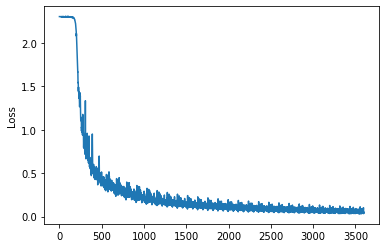

In [149]:
nn = NeuralNet(784, 10)

loss_history, a, b = nn.Train(X_train, y_train, X_test, y_test, batch_size=500, num_epochs=30, verbose=True, learning_rate=2e-1)

plt.plot(loss_history)
plt.ylabel('Loss')
plt.show()

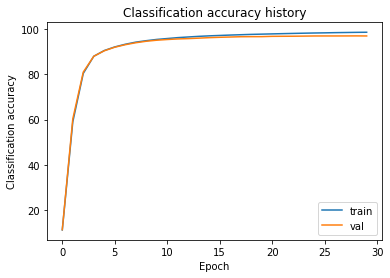

In [142]:
#plt.subplot(2, 1, 2)
plt.plot(a, label='train')
plt.plot(b, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

Actual Digit: 3
Network predicted: 3
Actual Digit: 0
Network predicted: 0
Actual Digit: 9
Network predicted: 9
Actual Digit: 6
Network predicted: 6
Actual Digit: 9
Network predicted: 9
Actual Digit: 3
Network predicted: 3
Actual Digit: 3
Network predicted: 3
Actual Digit: 3
Network predicted: 3
Actual Digit: 3
Network predicted: 3
Actual Digit: 3
Network predicted: 3
Actual Digit: 1
Network predicted: 1
Actual Digit: 3
Network predicted: 3
Actual Digit: 1
Network predicted: 1
Actual Digit: 6
Network predicted: 6
Actual Digit: 9
Network predicted: 9
Actual Digit: 6
Network predicted: 6
Actual Digit: 7
Network predicted: 7
Actual Digit: 0
Network predicted: 0
Actual Digit: 4
Network predicted: 4
Actual Digit: 9
Network predicted: 9
Actual Digit: 1
Network predicted: 1
Actual Digit: 2
Network predicted: 2
Actual Digit: 0
Network predicted: 0
Actual Digit: 2
Network predicted: 2
Actual Digit: 1
Network predicted: 1
Actual Digit: 8
Network predicted: 8
Actual Digit: 8
Network predicted: 8
A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:254: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Actual Digit: 1
Network predicted: 1
Actual Digit: 3
Network predicted: 3
Actual Digit: 5
Network predicted: 5
Actual Digit: 9
Network predicted: 9
Actual Digit: 3
Network predicted: 3
Actual Digit: 7
Network predicted: 7
Actual Digit: 8
Network predicted: 8


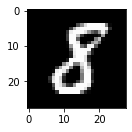

In [150]:
num = 100
num = np.random.choice(10000, 100, replace=True)

for i in num:
  nn.Predict(X_test, y_test, i)